In [ ]:
######  VISUALIZATOR #####

from unicodedata import name
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from statsmodels.graphics.tsaplots import plot_acf
import os


class visualizator:

    def __init__(self, name_model = ""):
        self.name_model = name_model

    def __validColumn(self, nameColumn):
        valid = ["hydro", "flow", "sys_reg", "total", "wind", "thermal", "micro" ]
        if nameColumn in valid: return True
        else: return False
    
    def correlationMap(self, data):
        corrMat = data.corr()
        sn.heatmap(corrMat, annot=True)
        plt.title('Correlation Map')
        plt.show()
        return plt
        

    def plotDataY(self, data, pre_outliers):
        plt.scatter(x = [range(0,len(data))], y = data)
        if(pre_outliers == True):
          plt.title('Y values pre outliers process')
        else:
          plt.title('Y values post outliers process')
        plt.show()
        return plt


    def plotValues(self, data):
        figNum = 0
        for columnName, columnData in data.iteritems():
            if(self.__validColumn(columnName)):
                y = columnData
                plt.figure(figNum)
                fig, ax = plt.subplots(figsize=(20, 6))
                ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label= columnName)
                plt.title('Values of a column name' + columnName)
                ax.set_ylabel('Values')
                ax.legend()
                figNum = figNum +1 
        
        plt.show()
        return plt
    
    def __plotRange(self, series, true_val, pred):
      if (not len(series)== 1):
        if (true_val.min() < pred.min() and true_val.min() < series.min()):
          min = true_val.min()
        elif(pred.min() < true_val.min() and pred.min() < series.min()):
          min = pred.min()        
        else:
          min = series.min()
          
        if (true_val.max() > pred.max() and true_val.max() > series.max()):
          max = true_val.max()
        elif(pred.max() > true_val.max() and pred.max() > series.max()):
          max = pred.max()
        else:
          max = series.max()
      
      else:
        if (true_val.min() < pred.min()):
          min = true_val.min()
        else:
          min = pred.min()
            
        if (true_val.max() > pred.max()):
          max = true_val.max()
        else:
          max = pred.max()
        
      return min-0.15, max+0.15


    def plotForecasts2(self, y_true, y_pred, init_time, name_plot):
        plt.plot(y_true, label='Actual')
        plt.plot(y_pred, label='Predicted')
        min, max = self.__plotRange(np.array([0]), np.array(y_true), np.array(y_pred))
        plt.ylim([min, max])
        plt.title('Target and predicted values' + str(init_time))
        plt.legend()
        plt.show()
        path = os.path.join(self.name_model, name_plot)
        plt.savefig(path)

    def plotForecasts(self, series,  n_test, forecasts, init_time, name_plot):
        # plot the entire dataset in blue
        min, max = self.__plotRange(np.array(series), np.array(n_test), np.array(forecasts))
        plt.ylim([min, max])
        plt.plot(series, label='Historical')
        off_s = len(series) 
        off_e = len(series) + len(forecasts) 
        xaxis = [x for x in range(off_s, off_e)]
        plt.plot(xaxis, forecasts, color = "red", label='Predicted')
        plt.plot(xaxis, n_test, color = "green", label= "Real Values")
        plt.title('Historic, target and predicted values' + str(init_time))
        plt.legend()
        plt.show()
        return plt

    def lossPlotEpoch(self, epoch):
        EPOCH = epoch # number of epochs the model has trained for

        history_dataframe = pd.read_csv(self.name_model+'/model_history.csv',sep=',')


        # Plot training & validation loss values
        plt.style.use("ggplot")
        plt.plot(range(1,EPOCH+1),
                history_dataframe['loss'])
        plt.plot(range(1,EPOCH+1),
                history_dataframe['val_loss'],
                linestyle='--')
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()
        return plt

    
    def save_figure(self, name_plot, plot):
      path = os.path.join(self.name_model, name_plot)
      plot.savefig(path)


###################################################################
###################################################################
###################################################################

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
##### DATA MANAGER #####
import pandas as pd
import csv
from numpy import percentile
import os 
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import StandardScaler, MinMaxScaler, SplineTransformer
from numpy import array

#from visualizator import * 


class dataManager: 

    def __init__(self, path:str = ""):
        self.pth = path
        self.vis = visualizator()


    def __plotData(self, data):
        plt.scatter(x = [range(0,len(data))], y = data)
        plt.show()
        
    #######################################    
    ######### PUBLIC FUNCTIONS ############
    #######################################

    def getData (self, normalization= "MinMax", altered_forecast = False):
        pathAct= os.getcwd()
        ##FOR THE DEMOSTRATION, USE TO GET ONE FILE WITH THE NAME INTRODUCED ON INIT
        pathDataTrain = os.path.join(pathAct, "data", "no1_train.csv")
        pathDataVal = os.path.join(pathAct, "data", "no1_validation.csv")

        #######CHANGE FOR GET THE FILE IN DEMO##############
        
        pdSetTrain= pd.read_csv("/content/no1_train.csv")
        pdSetVal = pd.read_csv("/content/no1_validation.csv")
        
        pdSetTrain["flow"] = -pdSetTrain["flow"]
        pdSetVal["flow"] = -pdSetVal["flow"]

        ####################################################
        
        ########DATA PREPROCESSING#########

        if(altered_forecast == True):
          pdSetTrain = self.altered_forecast_pre(pdSetTrain)
          pdSetVal = self.altered_forecast_pre(pdSetVal)

        plt = self.vis.correlationMap(pdSetTrain)

        pdSetTrain= self.__nonUsefulVars(pdSetTrain)
        pdSetVal= self.__nonUsefulVars(pdSetVal)
        
        pdSetTrain = self.__addLaggedVar(pdSetTrain)
        pdSetVal = self.__addLaggedVar(pdSetVal)

        pdSetTrain = self.__OutliersProcess(pdSetTrain)
        pdSetVal = self.__OutliersProcess(pdSetVal)

        self.__addCategoricalVars(pdSetTrain)
        self.__addCategoricalVars(pdSetVal)

        pdSetTrain.drop('start_time', inplace=True, axis=1)
        pdSetVal.drop('start_time', inplace=True, axis=1)
        
        pdSetTrain = self.normalizeData(pdSetTrain, normalization)
        pdSetVal = self.normalizeData(pdSetVal, normalization)

        return pdSetTrain, pdSetVal

    def altered_forecast_pre(self, data):
      spline = SplineTransformer(degree=2, n_knots=3)
      flow = data.loc[:, 'flow'].to_numpy()
      total = data.loc[:,'total'].to_numpy()
      y = data.loc[:,'y'].to_numpy()
      suma_cols = np.sum([total, flow], axis=0)
      suma_cols = suma_cols.reshape(-1,1)
      interp = spline.fit_transform(suma_cols)
      interpList = []
      for i in interp:
        suma = np.sum(i)
        interpList.append(suma)
      
      interp = np.array(interpList)
      resta = np.subtract(interp, suma_cols)
      y = np.subtract(y, resta)
      data.drop("y", axis = 1,inplace= True)
      data["y"] = pd.Series(y)
    
    def getTarget(self, dataframe, timeStep = 144, test = False):
        if (test == True):
            dataframe.reset_index(drop= True, inplace= True)
        dataY = dataframe["y"].copy().sort_index(axis=0)
        dataX = dataframe.drop("y", axis = 1)
        last_dim = len(dataX.columns)
        ###DADES DE TEST
        if (test == True):
            return dataX, dataY
        X, y = self.split_sequence(dataX, dataY, timeStep,test)
        X = X.reshape((X.shape[0], X.shape[1], last_dim))
        y = y.reshape((y.shape[0], 1))
        return X, y

    ### DATA SHAPING ### 
    def split_sequence(self, dataX, dataY, n_steps_in, test):
        X, y = list(), list()
        for i in range(len(dataX)):
            # find the end of this pattern
            end_ix = i + n_steps_in
            # check if we are beyond the sequence
            if end_ix >= len(dataX):
                break
            # gather input and output parts of the pattern
            seq_x, seq_y = dataX[i:end_ix], dataY[end_ix]
            X.append(seq_x)
            y.append(seq_y)
        return array(X), array(y)

    #######################################
    ## NORMALIZATION/STANDARIZATION CODE ##
    #######################################
    

    def __normalization(self, data):
        max = data.max()
        norm_data = data/max
        return norm_data

    def normalizeData(self, data, type:str):
      dataCopy = data
      if (type == "normalize"):
          for column in data:
              dataCopy[column]= self.__normalization(dataCopy[column]).values
        
      elif(type== 'MinMax'):
          scaler = MinMaxScaler(feature_range=(-1,1))
          dataCopy = pd.DataFrame(scaler.fit_transform(dataCopy.values), columns=dataCopy.columns, index=dataCopy.index)
      
      elif(type == "Standard"):
          ss = StandardScaler()
          dataCopy = pd.DataFrame(ss.fit_transform(dataCopy),columns = dataCopy.columns)
      
      return dataCopy


   
    #######################################
    ######## ADDITION OF VARIABLES ########
    #######################################

    '''
    Add a column of variables that defines the time of the day:
    'N' : Night time --> 1
    'M' : Morning --> 2
    'A' : Afternoon --> 3
    '''
    def __addHourVars(self, timeData):
        hours = []
        for _, hour in timeData.items():
            if(hour > 21 and hour < 7): hours.append(1)
            elif(hour > 7 and hour < 15 ): hours.append(2)
            else: hours.append(3)
        return hours
                
    '''
    S'HA D'ACABAR

    Add a column of variables that defines the time of the day:
        Week days --> 1
        Weekend --> 2
    '''
    def __addWeekVars(self, timeData):
        weekMom = []
        for _, value in timeData.items():
            if (value < 4):
                weekMom.append(0)
            
            else: weekMom.append(1)
        
        return weekMom

    '''
    Add a column of variables that defines the time of the day:
        Winter --> 1
        Spring --> 2
        Summer --> 3
        Autumn --> 4
    '''
    def __addYearVars(self,timeData):
        seasons=[]
        for _, season in timeData.items():
            if(season == 12 or season < 4): seasons.append(1)
            elif(season >= 4 and season < 6): seasons.append(2)
            elif(season >= 6 and season <= 8): seasons.append(3)
            else: seasons.append(4)
        
        return seasons
 
    ######CHANGE THIS SO IT ADDS VARIABLES 

    '''
    Returns a pandas dataset with time variables
    '''    
    def __addCategoricalVars(self, data):
        data['start_time'] = pd.to_datetime(data['start_time'],format='%Y-%m-%d %H:%M:%S', errors='coerce')
        data['season'] = self.__addYearVars(data['start_time'].dt.month)
        data['moment_week']=self.__addWeekVars(data['start_time'].dt.dayofweek) 
        data['time_of_the_day'] = self.__addHourVars(data['start_time'].dt.hour) 
        
    '''
    Returns a pandas dataset with lagged variable
    '''
    def __addLaggedVar(self, data, previous_y = True, prev_24h_y = True):
      data_new = data
      y_column = data.loc[:,'y']
      if(previous_y):
        y_column1 = y_column.iloc[:-1].values
        data_new = data_new.iloc[1:,:]
        data_new['previous_y']= y_column1.tolist()
      
      if(prev_24h_y):
        y_column2 = y_column.iloc[:-289].values
        data_new = data_new.iloc[288:, :]
        data_new['prev_24h_y']= y_column2.tolist()
      
      data_new.reset_index(drop= True, inplace= True)
      data_new.info
      return data_new

    #######################################
    ##### PRE-PROCESSING OF VARIABLES #####
    #######################################

    '''
    Returns a pandas dataset without outliers
    '''
    def __OutliersProcess(self, pandDataSet):
        pdDataSet= pandDataSet.loc[:,'y'].to_list()
        qLow, qUp = percentile(pdDataSet, 0.5), percentile(pdDataSet, 99.5)
        for i in range(1,len(pdDataSet)):
            if(pdDataSet[i] < qLow or pdDataSet[i] > qUp):
                pandDataSet.at[i,'y'] = (pdDataSet[i-1]+pdDataSet[i+1])/2
        return pandDataSet

    def __nonUsefulVars(self, pandDataSet):
        newpd= pandDataSet.drop('river', axis = 1)
        return newpd
      

###################################################################
###################################################################
###################################################################
    

In [ ]:
#### DATA TEST PROCESS ####

import pandas as pd
from numpy import percentile
import os 
import matplotlib.pyplot as plt 
from IPython.display import display
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import SplineTransformer
from numpy import array
import numpy as np

class dataTestProcess:

    def __init__(self, path:str = "" ):
        self.pth = path
        self.vis = visualizator()
    

    def __dateTimeToIndex(self, datetime, data):
        dataCopy = data
        dataCopy['start_time'] = pd.to_datetime(dataCopy['start_time'],format='%Y-%m-%d %H:%M:%S', errors='coerce')
        return dataCopy.index[dataCopy['start_time'] == datetime].to_list()

    #######################################    
    ######### PUBLIC FUNCTIONS ############
    #######################################

    def getData (self, datetime, normalization = "minmax", altered_forecast = False):
        pathAct= os.getcwd()
        pathDataTest = os.path.join(pathAct, "data", self.pth)

        #######CHANGE FOR GET THE FILE IN DEMO##############
        
        pdSetTrain= pd.read_csv(pathDataTest)

        ####################################################
        
        ########DATA PREPROCESSING#########
        self.vis.correlationMap(pdSetTrain)
        pdSetTrain= self.__nonUsefulVars(pdSetTrain)

        print("-------------------")
        print("NONE USEFUL VARIABLES PROCESSED")
        print("-------------------")

        if(altered_forecast == True):
          pdSetTrain = self.altered_forecast_pre(pdSetTrain)

        pdSetTrain = self.__OutliersProcess(pdSetTrain)
        print("-------------------")
        print("OUTLIERS PROCESSED")
        print("-------------------")

        print("add previous y variable? (yes/no)")
        inpt_previous_y = input()
        previous_y = True
        if(inpt_previous_y == "no"):
            previous_y = False
        
        print("add previous 24h y variable? (yes/no)")
        inpt_previous_y = input()
        previous_24h_y = True
        if(inpt_previous_y == "no"):
            previous_24h_y = False

        pdSetTrain = self.__addLaggedVar(pdSetTrain, previous_y, previous_24h_y)

        print("-------------------")
        print("LAGGED VARIABLES ADDED")
        print("-------------------")

        self.__addCategoricalVars(pdSetTrain)
        print("-------------------")
        print("CATEGORICAL VARIABLES ADDED")
        print("-------------------")
        
        if (not datetime == -1):
            index = self.__dateTimeToIndex(datetime, pdSetTrain)[0]

        else:
            index = -1

        pdSetTrain.drop('start_time', inplace=True, axis=1)
        pdSetTrain = self.normalizeData(pdSetTrain, normalization)
        print("-------------------")
        print("DATA NORMALIZED")
        print("-------------------")

        return pdSetTrain, index, previous_y

    def altered_forecast_pre(self, data):
        spline = SplineTransformer(degree=2, n_knots=3)
        flow = data.loc[:, 'flow'].to_numpy()
        total = data.loc[:,'total'].to_numpy()
        y = data.loc[:,'y'].to_numpy()
        suma_cols = np.sum([total, flow], axis=0)
        suma_cols = suma_cols.reshape(-1,1)
        interp = spline.fit_transform(suma_cols)[:][0]

        resta = np.subtract(interp, suma_cols)
        y = np.subtract(y, resta)
        data.drop("y", axis = 1, inplace= True)
        data["y"] = pd.Series(y)

    #######################################
    ## NORMALIZATION/STANDARIZATION CODE ##
    #######################################
    

    def __normalization(self, data):
        max = data.max()
        norm_data = data/max
        return norm_data

    def normalizeData(self, data, type:str):
      dataCopy = data
      if (type == "normalize"):
          for column in data:
              dataCopy[column]= self.__normalization(dataCopy[column]).values
        
      elif(type== 'minmax'):
          print("entro a minmax")
          scaler = MinMaxScaler(feature_range=(-1,1))
          dataCopy = pd.DataFrame(scaler.fit_transform(dataCopy.values), columns=dataCopy.columns, index=dataCopy.index)
      
      elif(type == "std"):
          ss = StandardScaler()
          dataCopy = pd.DataFrame(ss.fit_transform(dataCopy),columns = dataCopy.columns)
      
      return dataCopy


   
    #######################################
    ######## ADDITION OF VARIABLES ########
    #######################################

    '''
    Add a column of variables that defines the time of the day:
    'N' : Night time --> 1
    'M' : Morning --> 2
    'A' : Afternoon --> 3
    '''
    def __addHourVars(self, timeData):
        hours = []
        for _, hour in timeData.items():
            if(hour > 21 and hour < 7): hours.append(1)
            elif(hour > 7 and hour < 15 ): hours.append(2)
            else: hours.append(3)
        return hours
                
    '''
    S'HA D'ACABAR

    Add a column of variables that defines the time of the day:
        Week days --> 1
        Weekend --> 2
    '''
    def __addWeekVars(self, timeData):
        weekMom = []
        for _, value in timeData.items():
            if (value < 4):
                weekMom.append(0)
            
            else: weekMom.append(1)
        
        return weekMom

    '''
    Add a column of variables that defines the time of the day:
        Winter --> 1
        Spring --> 2
        Summer --> 3
        Autumn --> 4
    '''
    def __addYearVars(self,timeData):
        seasons=[]
        for _, season in timeData.items():
            if(season == 12 or season < 4): seasons.append(1)
            elif(season >= 4 and season < 6): seasons.append(2)
            elif(season >= 6 and season <= 8): seasons.append(3)
            else: seasons.append(4)
        
        return seasons
 
    ######CHANGE THIS SO IT ADDS VARIABLES 

    '''
    Returns a pandas dataset with time variables
    '''    
    def __addCategoricalVars(self, data):
        data['start_time'] = pd.to_datetime(data['start_time'],format='%Y-%m-%d %H:%M:%S', errors='coerce')
        data['season'] = self.__addYearVars(data['start_time'].dt.month)
        data['moment_week']=self.__addWeekVars(data['start_time'].dt.dayofweek) 
        data['time_of_the_day'] = self.__addHourVars(data['start_time'].dt.hour) 
        
    '''
    Returns a pandas dataset with lagged variable
    '''
    def __addLaggedVar(self, data, previous_y = True, prev_24h_y = True):
      data_new = data
      y_column = data.loc[:,'y']
      if(previous_y and prev_24h_y):
        y_column1 = y_column.iloc[:-1].values
        data_new = data_new.iloc[1:,:]
        data_new['previous_y']= y_column1.tolist()

        y_column2 = y_column.iloc[:-289].values
        data_new = data_new.iloc[288:, :]
        data_new['prev_24h_y']= y_column2.tolist()
      
      elif(prev_24h_y):
        y_column2 = y_column.iloc[:-288].values
        data_new = data_new.iloc[288:, :]
        data_new['prev_24h_y']= y_column2.tolist()
      
      elif(previous_y):
        y_column1 = y_column.iloc[:-1].values
        data_new = data_new.iloc[1:,:]
        data_new['previous_y']= y_column1.tolist()
      
      data_new.reset_index(drop= True, inplace= True)
      data_new.info
      return data_new

    #######################################
    ##### PRE-PROCESSING OF VARIABLES #####
    #######################################

    '''
    Returns a pandas dataset without outliers
    '''
    def __OutliersProcess(self, pandDataSet):
        pdDataSet= pandDataSet.loc[:,'y'].to_list()
        qLow, qUp = percentile(pdDataSet, 0.5), percentile(pdDataSet, 99.5)
        for i in range(1,len(pdDataSet)):
            if(pdDataSet[i] < qLow or pdDataSet[i] > qUp):
                if(i < 2):
                    pandDataSet.at[i,'y'] = (pdDataSet[i+1]+pdDataSet[i+2]+
                    pdDataSet[i+3] + pdDataSet[i+4])/4
                
                elif(i > len(pdDataSet)-2):
                    pandDataSet.at[i,'y'] = (pdDataSet[i-1]+pdDataSet[i-2]+
                    pdDataSet[i-3] + pdDataSet[i-4])/4
                else:
                    pandDataSet.at[i,'y'] = (pdDataSet[i-2]+pdDataSet[i-1]+
                    pdDataSet[i+1] + pdDataSet[i+2])/4
        
        return pandDataSet

    def __nonUsefulVars(self, pandDataSet):
        newpd= pandDataSet.drop('river', axis = 1)
        return newpd
        

In [ ]:
##### MODEL ####
import tensorflow as tf
import numpy as np
import pickle
import os
import csv
import tensorflow.keras.backend as K
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from tensorflow.keras import activations

#####CHANGE THE MODEL NAME######
model_directory='/content/test_model/' # directory to save model history after every epoch 

class StoreModelHistory(keras.callbacks.Callback):

  def on_epoch_end(self,batch,logs=None):
    if ('lr' not in logs.keys()):
      logs.setdefault('lr',0)
      logs['lr'] = K.get_value(self.model.optimizer.lr)

    if not ('model_history.csv' in os.listdir(model_directory)):
      with open(model_directory+'model_history.csv','a') as f:
        y=csv.DictWriter(f,logs.keys())
        y.writeheader()

    with open(model_directory+'/model_history.csv','a') as f:
      y=csv.DictWriter(f,logs.keys())
      y.writerow(logs)

class forecastModel():

    ######  DATA SHOULD COME HERE AS A PANDAS DATAFRAME SO IT'S EASY TO USE ADAPT IT WHILE
    ###### WHILE WORKING
    def __init__(self, model_name = ""):
        self.model = None

    def constructModel(self, x_training_data):
        rnn = Sequential()
        rnn.add(LSTM(units = 64, return_sequences = True, 
                     input_shape = (x_training_data.shape[1], x_training_data.shape[2])))
        
        #rnn.add(LSTM(units = 64, input_shape = (x_training_data.shape[1], x_training_data.shape[2])))

        #Perform some dropout regularization
        rnn.add(Dropout(0.2))
        rnn.add(LSTM(units = 64))
        rnn.add(Dropout(0.2))

        #Adding our output layer
        rnn.add(Dense(units = 1))

        #Compiling the recurrent neural network
        rnn.compile(optimizer =keras.optimizers.Adam(), loss = 'mae')

        self.model = rnn

    def fitModel(self, Xtrain, ytrain, Xval, yval, save= False, test= False):
        early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
        self.model.fit(Xtrain, ytrain, batch_size= 96, epochs= 4, 
                        validation_data=(Xval, yval), callbacks=[early, StoreModelHistory()])

    def predictModel(self, Xtest, ytest):
        predict_values = self.model.predict(Xtest)
        return predict_values, ytest

    def saveModel(self, filename):
        if not os.path.exists(filename):
          os.mkdir(filename)
        filename = os.path.join(filename, filename)
        pickle.dump(self.model, open(filename, 'wb'))

    def loadModel(self, filename):
        filename = os.path.join(filename, filename)
        self.model = pickle.load(open(filename, 'rb'))

    def multiStepForecast(self, data, init_time = 0, used_y = True, timestep = 5):
        window_length = 24  if timestep == 5 else 8
        seq_len = 144
        seq_init = init_time
        dataCopy = data
        forecasts= []
        seq_final = seq_init+seq_len
        inputModel = dataCopy[seq_init:seq_final].to_numpy()
        forecast = self.model.predict(array([inputModel]))
        forecasts.append(forecast)
        for i in range (0, window_length-1):
            seq_init +=1
            seq_final +=1
            if(used_y):
              dataCopy.at[seq_final,'previous_y'] = forecast
            inputModel = dataCopy[seq_init:seq_final].to_numpy()
            forecast = self.model.predict(array([inputModel]))
            forecasts.append(forecast)
        
        return forecasts 
            

In [ ]:
#### TRAIN A MODEL PIPELINE ####

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
from IPython.display import display

dataMg = None
dataTestMg = None
modelClass= None
visual= None


print("Name model:")
name_model = input()
name_model = "/content/" + name_model



visual = visualizator(name_model)

Name model:
altered_forecast_model


In [ ]:
def pipelineData():
    ############# CHANGE FOR THE TEST PERFORMANCE ##############
    global visual
    global dataMg
    global dataTestMg
    train , val = dataMg.getData(altered_forecast = False)
    train, test = train_test_split(train, test_size=0.24, shuffle=False)
    XTrainSet, yTrainSet= dataMg.getTarget(train)
    XValSet, yValSet= dataMg.getTarget(val)
    XTestSet, yTestSet = dataMg.getTarget(test, test = True)
    return XTrainSet, yTrainSet, XTestSet, yTestSet, XValSet, yValSet


def pipelineModel(Xinput, yinput, XtestSet, yTestSet, Xval, yVal):
    global modelClass
    global visual
    modelClass.constructModel(Xinput)
    modelClass.fitModel(Xinput, yinput, Xval, yVal, False)

In [ ]:
dataMg = dataManager()  
XtrainSet, yTrainSet, XTestSet, yTestSet, Xval, yval = pipelineData() #, XTestSet, yTestSet, Xval, yval

In [ ]:
modelClass = forecastModel()
pipelineModel(XtrainSet, yTrainSet, XTestSet, yTestSet, Xval, yval)

In [ ]:
visual.lossPlotEpoch(4)

In [ ]:
import random as rd

visual = visualizator(name_model)
init_time = 144
for i in range (0,6):

    predict = modelClass.multiStepForecast(XTestSet, init_time= init_time-144)
    historicVal = yTestSet[init_time-144:init_time+1].to_numpy().flatten()
    targets = yTestSet[init_time:init_time+24].to_numpy().flatten()
    print(len(targets))
    predictPlot = np.array(predict).flatten()
    print(len(predictPlot))
    visual.plotForecasts2(targets, predictPlot, init_time -144, 'forecast_and_target_plot')
    visual.plotForecasts(historicVal, targets, predictPlot, init_time - 144, 'historic_forecast_and_target_plot' )
    init_time = rd.randint(144, 53808)

In [ ]:
modelClass.saveModel("test_model")

In [ ]:
######################################################################
######################################################################
######################################################################

Enter name of the data file
no1_test.csv
Normal forecast or Altered (0 or 1)
0
Type of normalization (std (Standard Scaler) / minmax  (MinMaxScaler)/ norm (normalization)
minmax
Choose fixed start time or do random set (0 or 1)
1


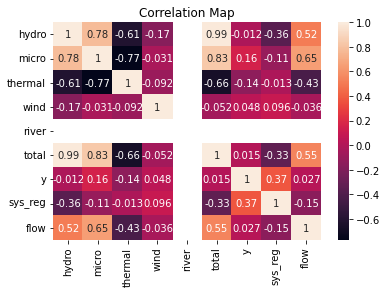

-------------------
NONE USEFUL VARIABLES PROCESSED
-------------------
-------------------
OUTLIERS PROCESSED
-------------------
add previous y variable? (yes/no)
yes
add previous 24h y variable? (yes/no)
yes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


-------------------
LAGGED VARIABLES ADDED
-------------------
-------------------
CATEGORICAL VARIABLES ADDED
-------------------
entro a minmax
-------------------
DATA NORMALIZED
-------------------


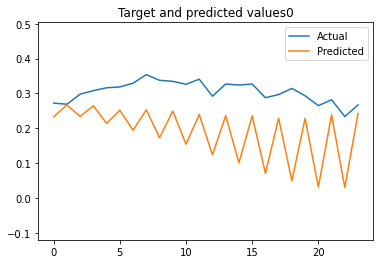

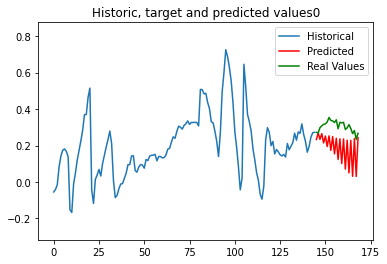

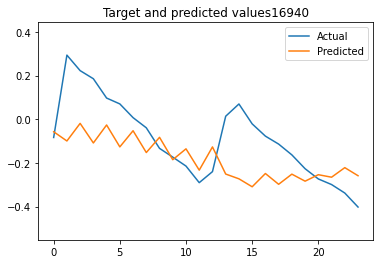

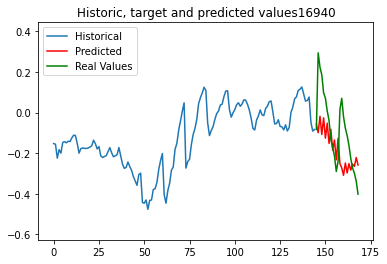

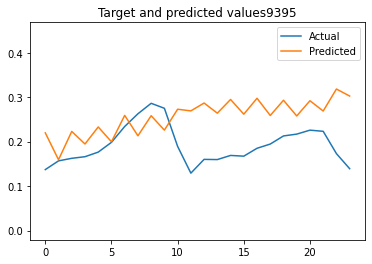

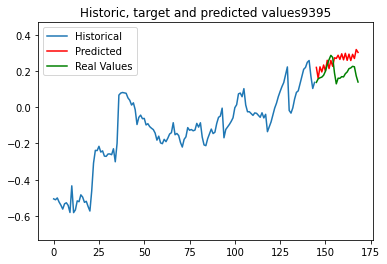

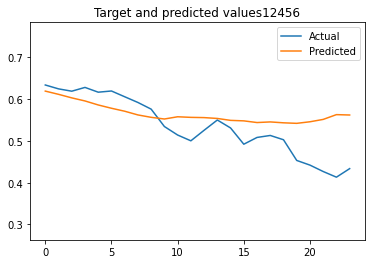

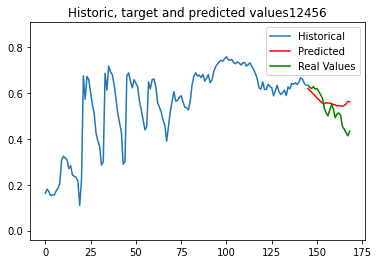

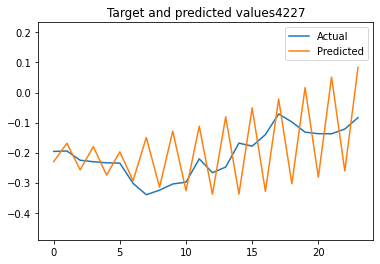

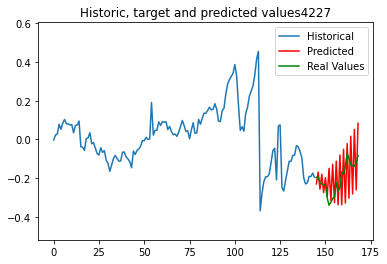

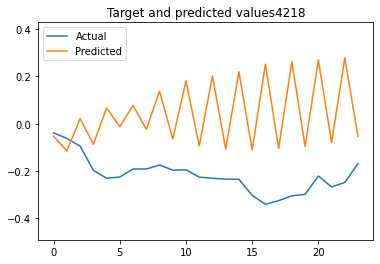

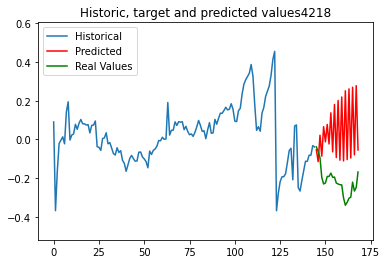

In [ ]:
#### TEST MODEL PIPELINE ####
import numpy as np
from sklearn.model_selection import train_test_split
from IPython.display import display
import os
from datetime import datetime
import random as rd

dataTestMgtst = None
modelClassTest= None
visualTest= None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       


def test_function(norm, start_date, altered_forcast):
    global dataTestMgtst
    global modelClassTest
    global visualTest

    data, index, previous_y  = dataTestMgtst.getData(start_date, norm, altered_forcast)
    dataY= data.loc[:,'y']
    data.drop('y', inplace= True, axis = 1)


    if (index == -1):
        init_time = 144
        for i in range (0,6):

            predict = modelClassTest.multiStepForecast(data, init_time-144, previous_y)
            historicVal = dataY[init_time-144:init_time+1].to_numpy().flatten()
            targets = dataY[init_time:init_time+24].to_numpy().flatten()
            predictPlot = np.array(predict).flatten()
            visualTest.plotForecasts2(targets, predictPlot, init_time -144, 
                                  'forecast_and_target_plot')
            
            visualTest.plotForecasts(historicVal, targets, predictPlot, 
                                 init_time - 144, 'historic_forecast_and_target_plot')
            
            init_time = rd.randint(144, len(data)-144)
    
    else:
        init_time = index
        predict = modelClassTest.multiStepForecast(data, init_time-144, previous_y)
        historicVal = dataY[init_time-144:init_time+1].to_numpy().flatten()
        targets = dataY[init_time:init_time+24].to_numpy().flatten()
        predictPlot = np.array(predict).flatten()
        visualTest.plotForecasts2(targets, predictPlot, 
                              init_time -144, 'forecast_and_target_plot')
        
        visualTest.plotForecasts(historicVal, targets, predictPlot, 
                             init_time - 144, 'historic_forecast_and_target_plot')

print("Enter name of the data file")
dataName= input()
visualTest = visualizator()
modelClassTest = forecastModel()
dataTestMgtst = dataTestProcess(dataName)


print("Normal forecast or Altered (0 or 1)")

forecast = input()
altered_forecast = False
if (forecast == '1'):
    altered_forecast = True
    modelClassTest.loadModel(os.path.join("/content", "altered_forecast_model", "altered_forecast_model"))
else: 
    modelClassTest.loadModel(os.path.join("/content","forecast_model_bo", "forecast_model_bo"))

print("Type of normalization (std (Standard Scaler) / minmax  (MinMaxScaler)/ norm (normalization)")
norm = input()

print("Choose fixed start time or do random set (0 or 1)")
fix = input()
    
if(fix == '0'):
    print("Start date to forecast (YY-MM-DD hh:mm:ss)(Should be at least 1 day after the begining of the data set)")
    date = input()
    date_time_obj = datetime.fromisoformat(date)
    print(date_time_obj)

else: 
    date_time_obj = -1

test_function(norm, date_time_obj, altered_forecast)